# Importing Necessary Libraries

In [1]:
import itertools
## Regular Expression
import re

## Arrays
import numpy as np

## DataFrames
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from IPython.display import Image

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import contractions
import spacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('max_columns',40)

# Reading the File

In [3]:
df = pd.read_csv('Cleaned_Women_ECommerce.csv')

In [4]:
df.head()

,Unnamed: 0,clothing_id,age,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,new_text,clean_text,review_length,rating_class,tokens
0,0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable,45,good,"['absolutely', 'wonderful', 'silky', 'sexy', '..."
1,1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store...,195,good,"['love', 'dress', 'sooo', 'pretty', 'happened'..."
2,2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,major design flaw high hope dress really wante...,338,neutral,"['major', 'design', 'flaw', 'high', 'hope', 'd..."
3,3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...",favorite buy love love love jumpsuit fun ...,110,good,"['favorite', 'buy', 'love', 'love', 'love', 'j..."
4,4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,flattering shirt shirt flattering due adjustab...,132,good,"['flattering', 'shirt', 'shirt', 'flattering',..."


In [5]:
df.drop('Unnamed: 0',axis = 1, inplace=True)

# Decreasing the Review Classes to Two (Bad(1,2) & Not Bad(3,4,5))

In [6]:
df.rating_class = df.rating_class.apply(lambda x: x.replace('neutral', 'good'))

In [7]:
df.rating_class = df.rating_class.apply(lambda x: x.replace('good', 'not bad'))

In [8]:
df.rating_class.value_counts()

not bad    20258
bad         2370
Name: rating_class, dtype: int64

# Confusion Matrix Function

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

# Natural Language Processing

In [10]:
cleaned_text = [str(txt) for text in df['clean_text'] for txt in text.split(' ') if len(txt)>2 and txt not in 'not, nan']
word_dist = nltk.FreqDist(cleaned_text)

# Adding the Most Common and the Least Common 70 Words to the Stopwords List

In [11]:
stopword_list= stopwords.words('english')
stopword_list= stopwords.words('english')
for y in word_dist.most_common()[-70:]:
    stopword_list.append(y[0])
mst_c = word_dist.most_common()[:70]
for x in mst_c:
    stopword_list.append(x[0])

In [12]:
print(len(stopword_list))

319


In [13]:
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) for w in text.split(' ') if w not in stopword_list]))

# Splitting the Data Set into Train and Test Sets

In [14]:
text = df['clean_text']
target = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.25, random_state=5, stratify = target)

In [15]:
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(16971,)
Test Set Shape		:(5657,)


# Count Vectorizing of the Train and Test Sets

In [16]:
count_vect = CountVectorizer(ngram_range=(1,3), min_df=0.002, max_df=0.998)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [17]:
print('Vocabulary len :', len(count_vect.get_feature_names()))
print('Longest word   :', max(count_vect.vocabulary_, key=len))

Vocabulary len : 1521
Longest word   : received many compliment


In [18]:
vocab = count_vect.get_feature_names()

In [19]:
#vocab = count_vect.get_feature_names()
pd.DataFrame(count_vect_train, columns=vocab).head(5)

,able,absolutely,absolutely gorgeous,accent,accentuates,accessory,accurate,across,across bust,across chest,actual,actually,add,added,adding,addition,addition wardrobe,additional,adjust,adjustable,...,wrinkled,wrist,write,wrong,xl,xsp,xx,xxsp,yarn,year,year old,year round,yellow,yes,yesterday,yet,yoga,zip,zipped,zipper
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Logistic Regression with CountVectorizing

In [20]:
logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.8564610217429733


In [21]:
print (classification_report(y_test, y_pred_lr_CV))

             precision    recall  f1-score   support

        bad       0.40      0.72      0.51       592
    not bad       0.96      0.87      0.92      5065

avg / total       0.91      0.86      0.87      5657



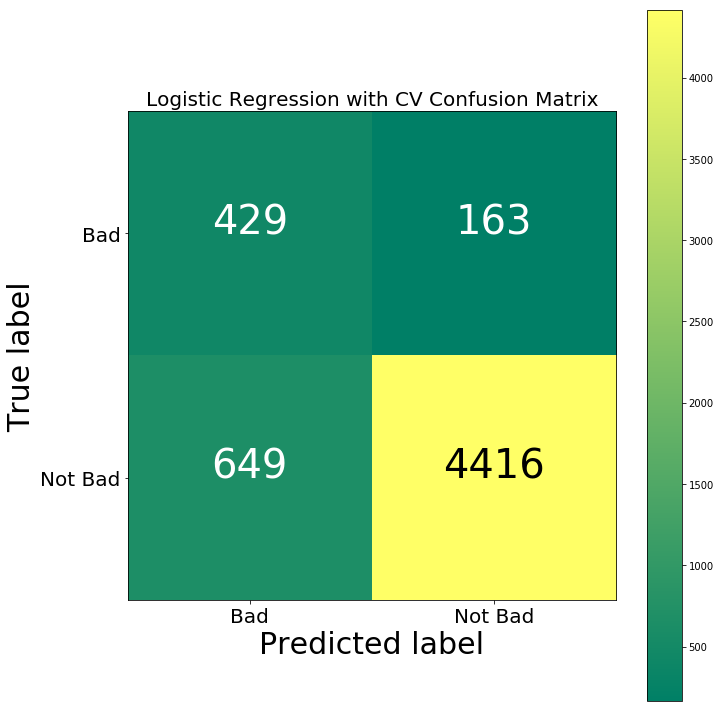

[[ 429  163]
 [ 649 4416]]


In [22]:
cm = confusion_matrix(y_test, y_pred_lr_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Logistic Regression with CV Confusion Matrix')
plt.show()
print(cm)

# Train Set Logistic Regression Accuracy Score

In [23]:
print('Accuracy :', metrics.accuracy_score(y_train, logreg_CV.predict(count_vect_train)))

Accuracy : 0.9013611454834718


# Train Set Logistic Regression Classification Report

In [24]:
print (classification_report(y_train, logreg_CV.predict(count_vect_train)))

             precision    recall  f1-score   support

        bad       0.52      0.96      0.67      1778
    not bad       0.99      0.89      0.94     15193

avg / total       0.94      0.90      0.91     16971



# Train Set Logistic Regression Confusion Matrix

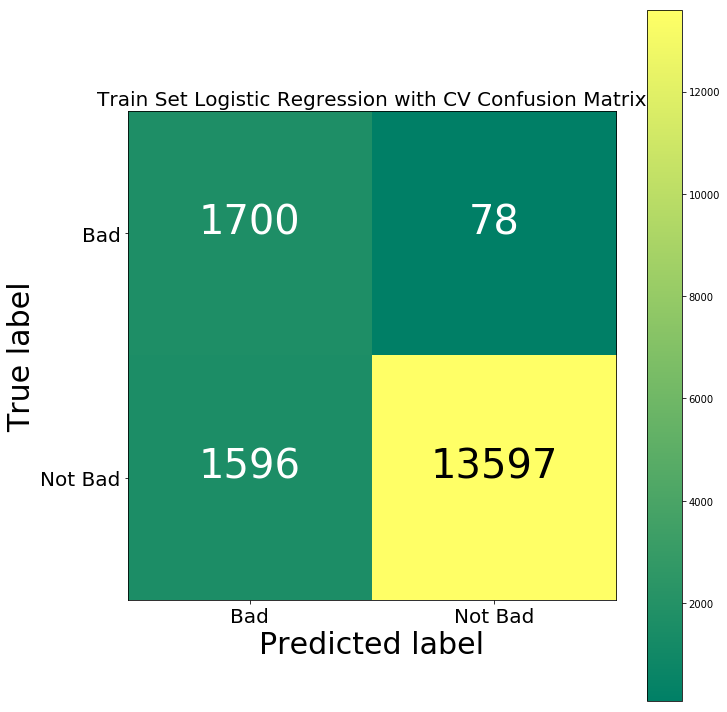

[[ 1700    78]
 [ 1596 13597]]


In [25]:
cm = confusion_matrix(y_train, logreg_CV.predict(count_vect_train))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Train Set Logistic Regression with CV Confusion Matrix')
plt.show()
print(cm)

# Random Forest with CountVectorizing

In [26]:
rf_CV = RandomForestClassifier(random_state=5)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.8893406399151493


In [27]:
print (classification_report(y_test, y_pred_rf_CV))

             precision    recall  f1-score   support

        bad       0.44      0.23      0.30       592
    not bad       0.91      0.97      0.94      5065

avg / total       0.87      0.89      0.87      5657



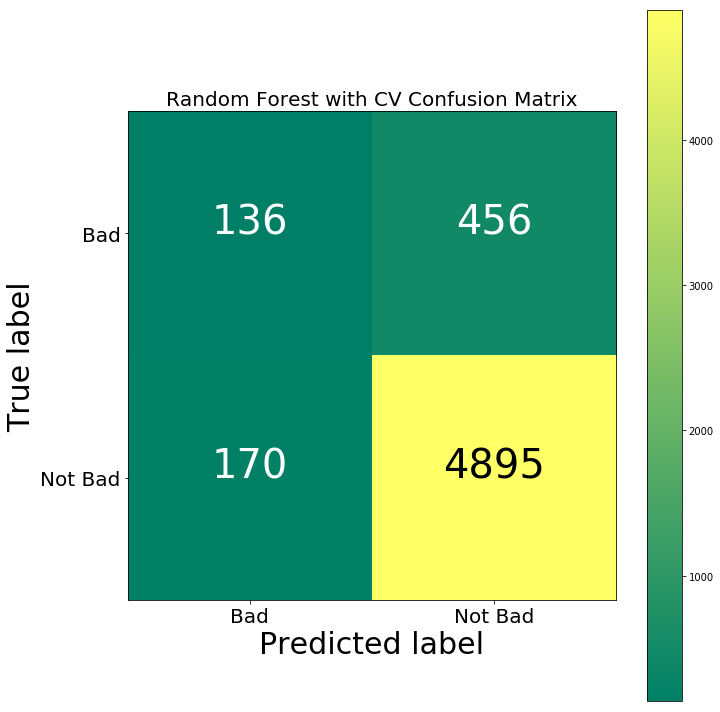

[[ 136  456]
 [ 170 4895]]


In [28]:
cm = confusion_matrix(y_test, y_pred_rf_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Random Forest with CV Confusion Matrix')
plt.show()
print(cm)

# LinearSVM with CountVectorizing

In [29]:
ln_SVM_CV = LinearSVC(random_state=5)
ln_SVM_CV.fit(count_vect_train, y_train)
y_pred_SVM_CV = ln_SVM_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_SVM_CV))

Accuracy : 0.9040127275941312


In [30]:
print (classification_report(y_test, y_pred_SVM_CV))

             precision    recall  f1-score   support

        bad       0.55      0.44      0.49       592
    not bad       0.94      0.96      0.95      5065

avg / total       0.90      0.90      0.90      5657



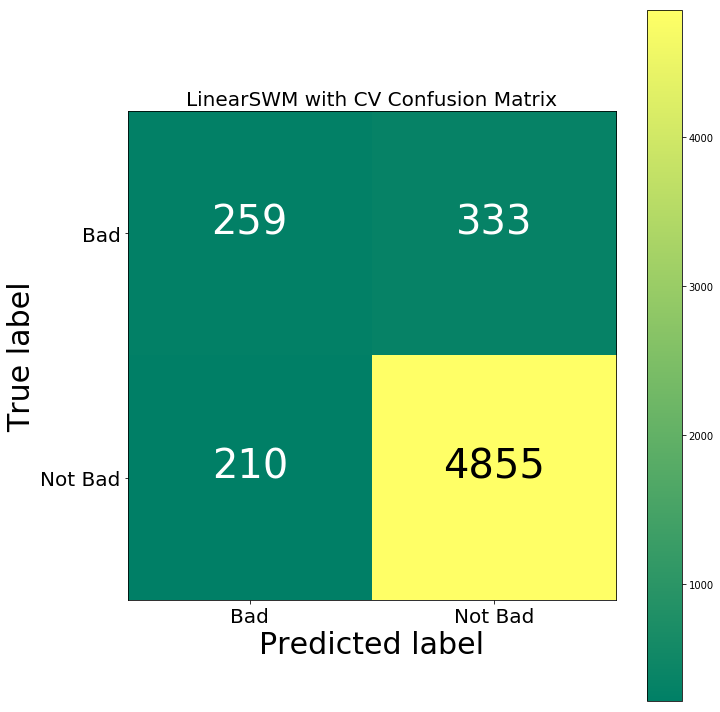

[[ 259  333]
 [ 210 4855]]


In [31]:
cm = confusion_matrix(y_test, y_pred_SVM_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='LinearSWM with CV Confusion Matrix')
plt.show()
print(cm)

# Gradient Boosting with CountVectorizing

In [32]:
gb_boost_cv = GradientBoostingClassifier()
gb_boost_cv.fit(count_vect_train, y_train)
y_pred_gb_boost = gb_boost_cv.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_gb_boost))

Accuracy : 0.9043662718755524


In [33]:
print (classification_report(y_test, y_pred_gb_boost))

             precision    recall  f1-score   support

        bad       0.69      0.16      0.26       592
    not bad       0.91      0.99      0.95      5065

avg / total       0.89      0.90      0.88      5657



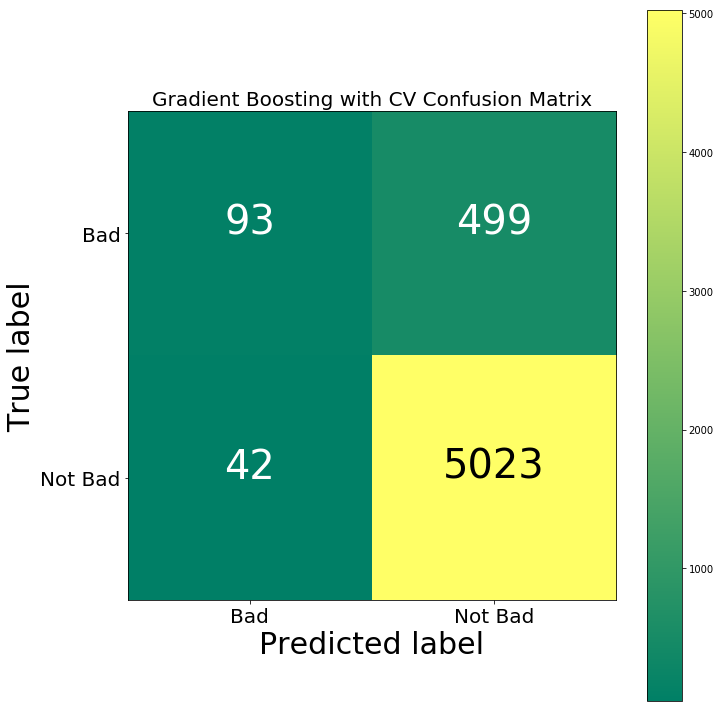

[[  93  499]
 [  42 5023]]


In [34]:
cm = confusion_matrix(y_test, y_pred_gb_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Gradient Boosting with CV Confusion Matrix')
plt.show()
print(cm)

# XG Boosting with CountVectorizing

In [35]:
xg_boost_CV = XGBClassifier()
xg_boost_CV.fit(count_vect_train, y_train)
y_pred_xg_boost = xg_boost_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_xg_boost))

Accuracy : 0.9025985504684462


In [36]:
print (classification_report(y_test, y_pred_xg_boost))

             precision    recall  f1-score   support

        bad       0.71      0.12      0.20       592
    not bad       0.91      0.99      0.95      5065

avg / total       0.89      0.90      0.87      5657



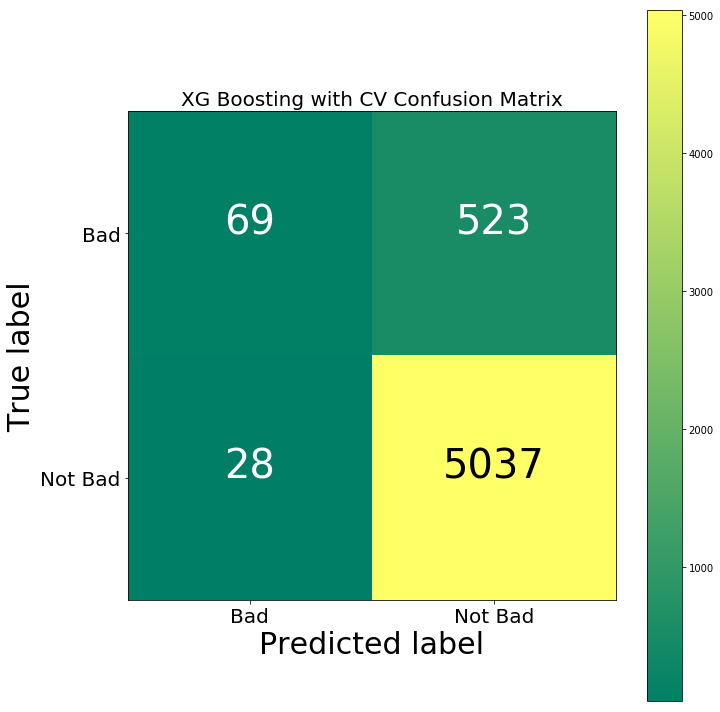

[[  69  523]
 [  28 5037]]


In [37]:
cm = confusion_matrix(y_test, y_pred_xg_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='XG Boosting with CV Confusion Matrix')
plt.show()
print(cm)

# Naive Bayes with CountVectorizing

In [38]:
MulNB_cv = MultinomialNB()
MulNB_cv.fit(count_vect_train, y_train)

y_pred_nb_cv = MulNB_cv.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_nb_cv))

Accuracy : 0.8845677921159625


In [39]:
print (classification_report(y_test, y_pred_nb_cv))

             precision    recall  f1-score   support

        bad       0.46      0.68      0.55       592
    not bad       0.96      0.91      0.93      5065

avg / total       0.91      0.88      0.89      5657



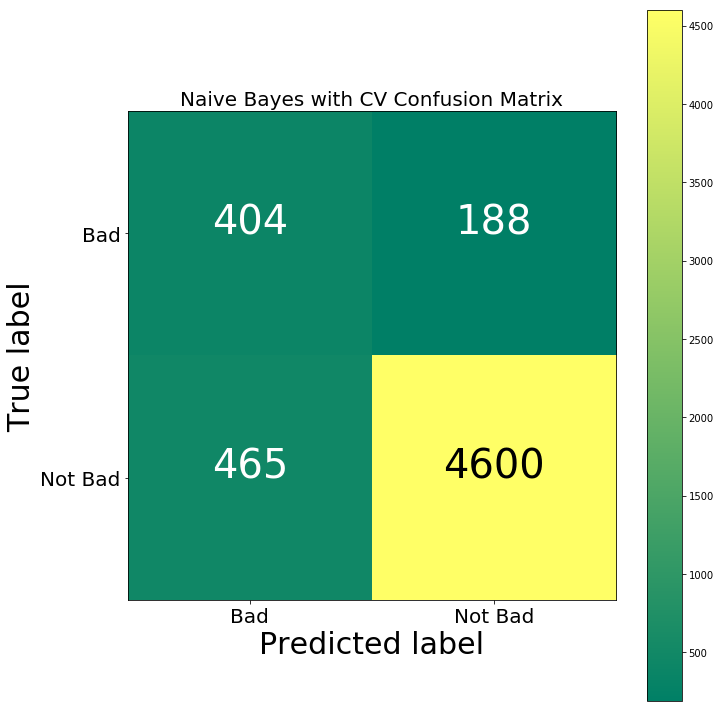

[[ 404  188]
 [ 465 4600]]


In [40]:
cm = confusion_matrix(y_test, y_pred_nb_cv)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Naive Bayes with CV Confusion Matrix')
plt.show()
print(cm)

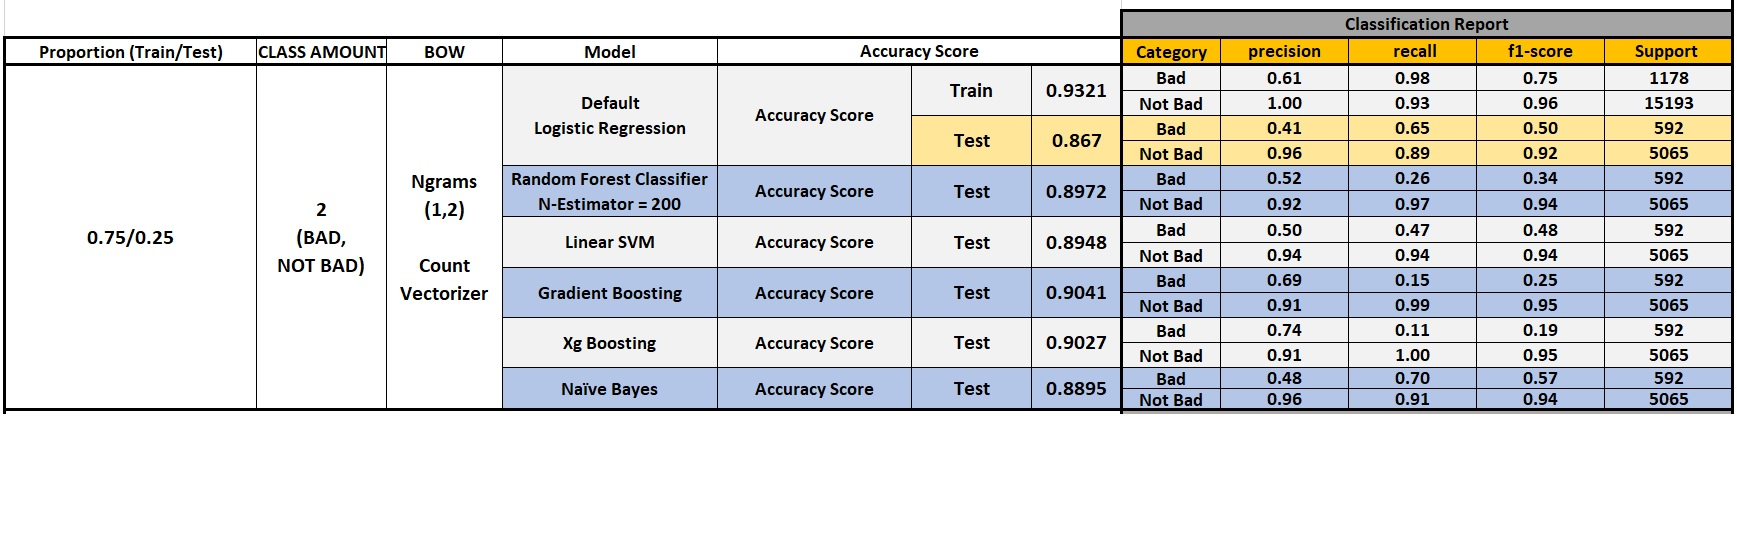

In [41]:
img = 'Stopwords_Ngrams(1,2).jpg'
Image(filename=img)

# SMOTE

In [42]:
from collections import Counter
from imblearn.over_sampling import SMOTE 
sm = SMOTE(ratio = 'minority', random_state=5)
df_text, df_target = sm.fit_sample(count_vect_train, y_train)
#print (count_vect_train.value_counts(), np.bincount(df_target))
print (df_text.shape)
print (df_target.shape)

(30386, 1521)
(30386,)


# Logistic Regression

In [43]:
logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              n_jobs=-1, random_state=5)
logreg_CV.fit(df_text, df_target)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.8465617818631783


In [44]:
print (classification_report(y_test, y_pred_lr_CV))

             precision    recall  f1-score   support

        bad       0.37      0.69      0.49       592
    not bad       0.96      0.86      0.91      5065

avg / total       0.90      0.85      0.87      5657



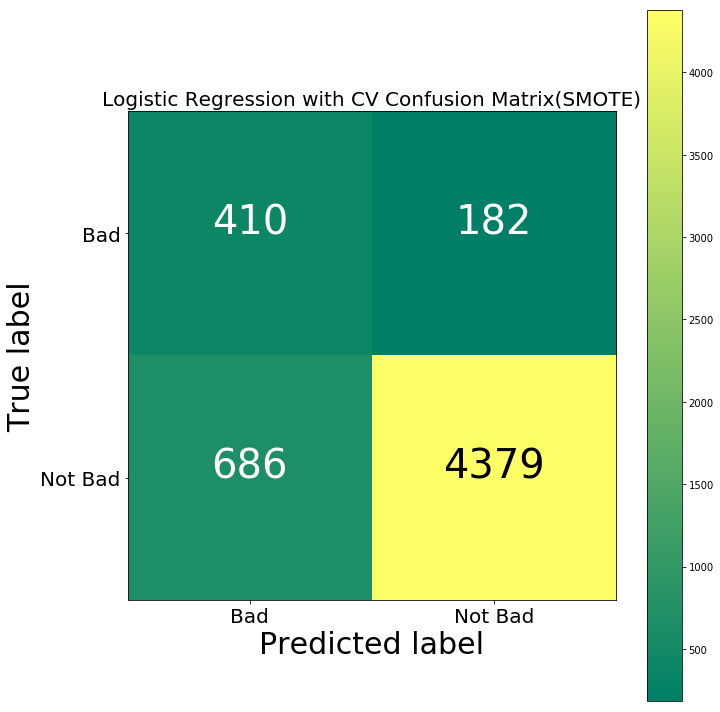

[[ 410  182]
 [ 686 4379]]


In [45]:
cm = confusion_matrix(y_test, y_pred_lr_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Logistic Regression with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Logistic Regression Train Set Accuracy

In [46]:
print('Accuracy :', metrics.accuracy_score(df_target, logreg_CV.predict(df_text)))

Accuracy : 0.926610939248338


In [47]:
print (classification_report(df_target, logreg_CV.predict(df_text)))

             precision    recall  f1-score   support

        bad       0.90      0.96      0.93     15193
    not bad       0.96      0.89      0.92     15193

avg / total       0.93      0.93      0.93     30386



# Random Forest with CountVectorizing

In [48]:
rf_CV = RandomForestClassifier(random_state=5)
rf_CV.fit(df_text, df_target)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.8919922220258087


In [49]:
print (classification_report(y_test, y_pred_rf_CV))

             precision    recall  f1-score   support

        bad       0.47      0.24      0.31       592
    not bad       0.92      0.97      0.94      5065

avg / total       0.87      0.89      0.88      5657



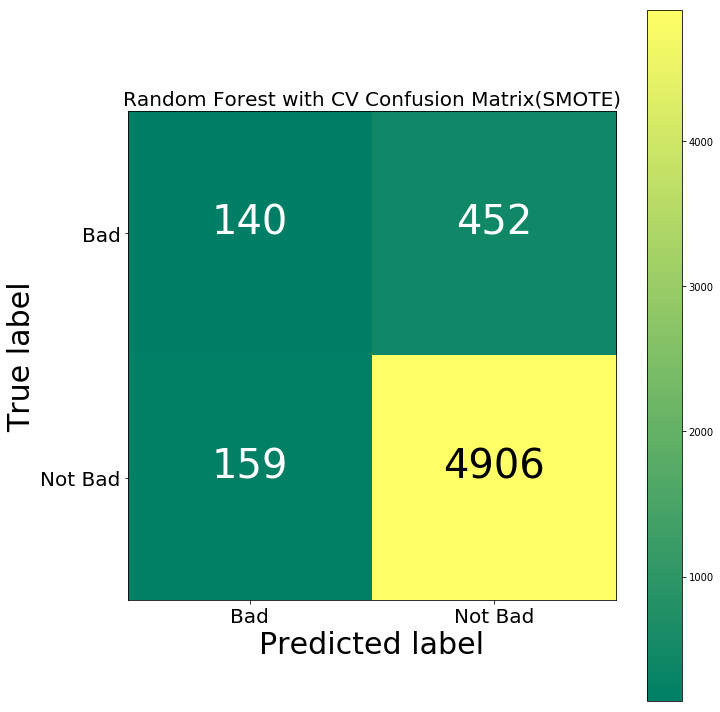

[[ 140  452]
 [ 159 4906]]


In [50]:
cm = confusion_matrix(y_test, y_pred_rf_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Random Forest with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# LinearSVM with CountVectorizing

In [51]:
ln_SVM_CV = LinearSVC(random_state=5)
ln_SVM_CV.fit(df_text, df_target)
y_pred_SVM_CV = ln_SVM_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_SVM_CV))

Accuracy : 0.842496022626834


In [52]:
print (classification_report(y_test, y_pred_SVM_CV))

             precision    recall  f1-score   support

        bad       0.37      0.69      0.48       592
    not bad       0.96      0.86      0.91      5065

avg / total       0.90      0.84      0.86      5657



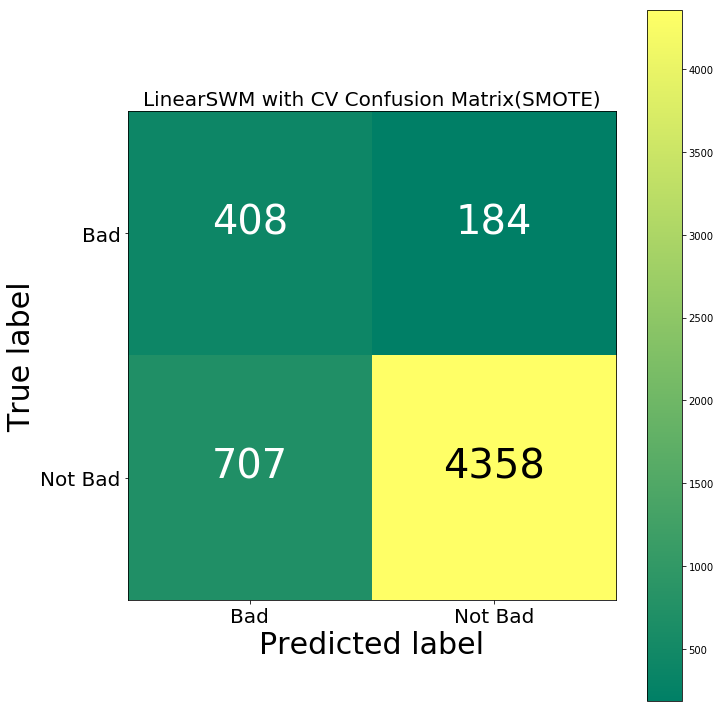

[[ 408  184]
 [ 707 4358]]


In [53]:
cm = confusion_matrix(y_test, y_pred_SVM_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='LinearSWM with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Gradient Boosting with CountVectorizing

In [54]:
gb_boost_cv = GradientBoostingClassifier()
gb_boost_cv.fit(df_text, df_target)
y_pred_gb_boost = gb_boost_cv.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_gb_boost))

Accuracy : 0.89800247480997


In [55]:
print (classification_report(y_test, y_pred_gb_boost))

             precision    recall  f1-score   support

        bad       0.52      0.36      0.43       592
    not bad       0.93      0.96      0.94      5065

avg / total       0.89      0.90      0.89      5657



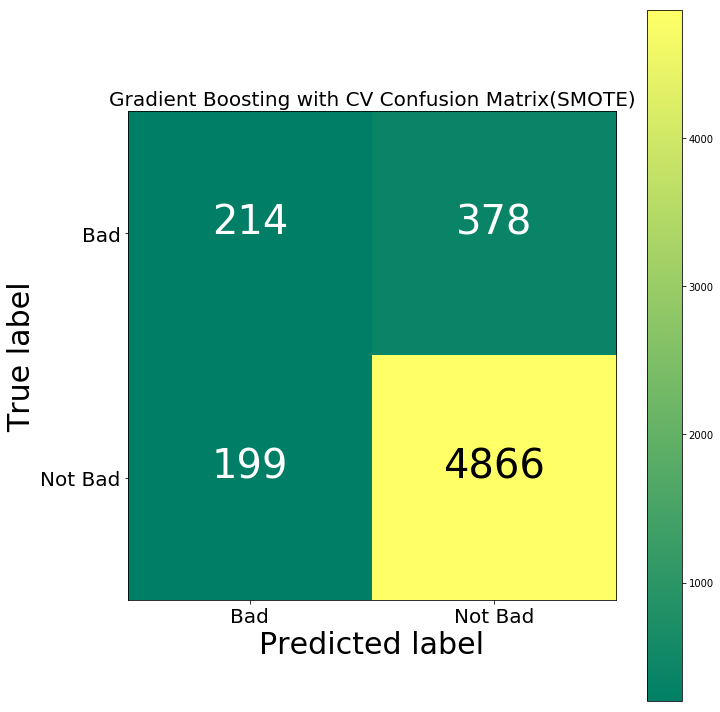

[[ 214  378]
 [ 199 4866]]


In [56]:
cm = confusion_matrix(y_test, y_pred_gb_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Gradient Boosting with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# XG Boosting with CountVectorizing

In [57]:
xg_boost_CV = XGBClassifier()
xg_boost_CV.fit(df_text, df_target)
y_pred_xg_boost = xg_boost_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_xg_boost))

Accuracy : 0.8990631076542337


In [58]:
print (classification_report(y_test, y_pred_xg_boost))

             precision    recall  f1-score   support

        bad       0.52      0.39      0.44       592
    not bad       0.93      0.96      0.94      5065

avg / total       0.89      0.90      0.89      5657



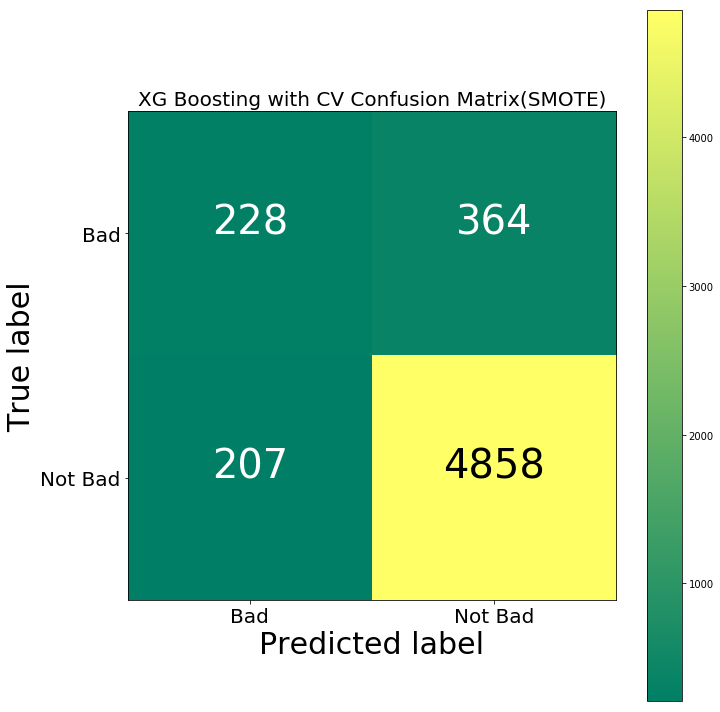

[[ 228  364]
 [ 207 4858]]


In [59]:
cm = confusion_matrix(y_test, y_pred_xg_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='XG Boosting with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Naive Bayes with CountVectorizing

In [60]:
MulNB_cv = MultinomialNB()
MulNB_cv.fit(df_text, df_target)

y_pred_nb_cv = MulNB_cv.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_nb_cv))

Accuracy : 0.8387838076719109


In [61]:
print (classification_report(y_test, y_pred_nb_cv))

             precision    recall  f1-score   support

        bad       0.38      0.83      0.52       592
    not bad       0.98      0.84      0.90      5065

avg / total       0.91      0.84      0.86      5657



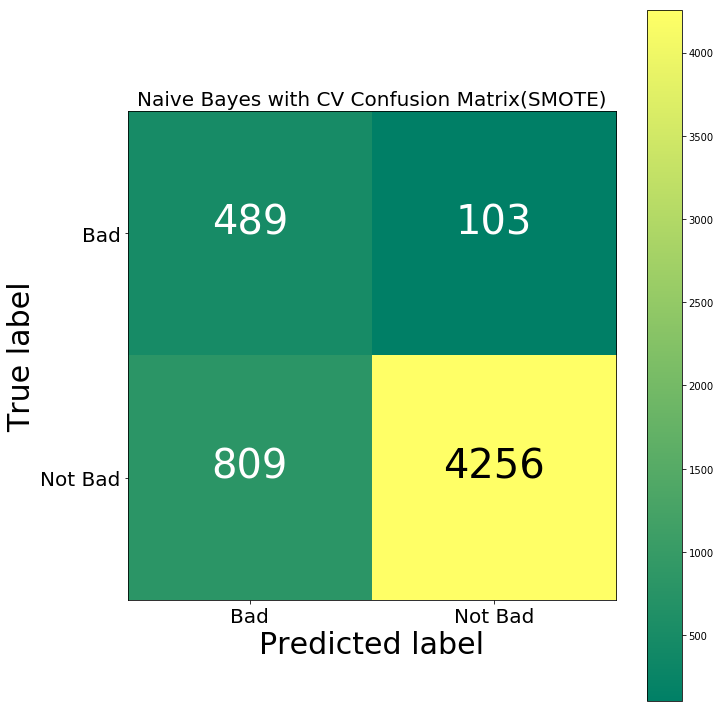

[[ 489  103]
 [ 809 4256]]


In [62]:
cm = confusion_matrix(y_test, y_pred_nb_cv)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Not Bad'], normalize=False, title='Naive Bayes with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

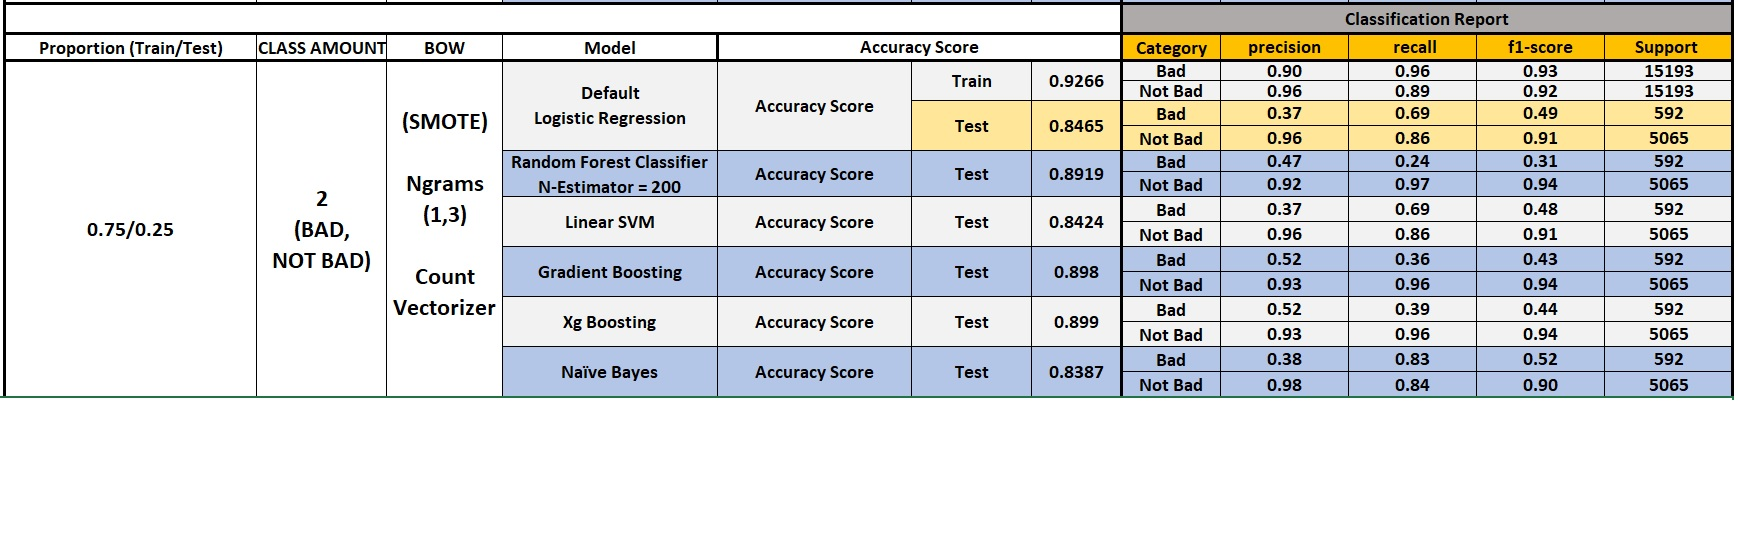

In [64]:
img = 'Stopwords_Ngrams(1,3)_SMOTE.jpg'
Image(filename=img)